In [6]:
from amuse.lab import *
from amuse.couple import bridge
from amuse.ext.orbital_elements import orbital_elements
from amuse.ic.fractalcluster import new_fractal_cluster_model
from tqdm import tqdm
import numpy as np
import csv
from matplotlib import pyplot as plt
import bisect

In [2]:
class MilkyWay_galaxy(object):
    def __init__(
        self, 
        Mb=1.40592e10 | units.MSun,
        Md=8.5608e10 | units.MSun,
        Mh=1.07068e11 | units.MSun,
    ):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self, eps, x, y , z):
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+(z**2+b2**2)**0.5)**2)**0.5
        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1 = r/a3
        c = 1 + (cut_off/a3)**1.02
        pot_halo = (
            -constants.G*(self.Mh/a3)*d1**1.02/(1+d1**1.02)
            -(constants.G*self.Mh/(1.02*a3))
            *(-1.02/c + np.log(c) + 1.02/(1+d1**1.02) - np.log(1.0 + d1**1.02))
        )
        return 2*(pot_bulge + pot_disk + pot_halo)

    def get_gravity_at_point(self, eps, x, y, z): 
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        b1 = 0.3873 | units.kpc
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        a3 = 12.0 | units.kpc

        # Forces
        force_bulge = -constants.G*self.Mb/(r**2+b1**2)**1.5
        d = a2 + (z**2+b2**2)**0.5
        force_disk = -constants.G*self.Md/(R**2+d**2)**1.5
        d1 = r/a3
        force_halo = -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))

        ax = force_bulge*x + force_disk*x + force_halo*x/r
        ay = force_bulge*y + force_disk*y + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2+b2**2)**0.5 + force_halo*z/r

        return ax, ay, az


def mass_to_radius(mass_array):
    radius_array = []
    for mass in mass_array:
        mass = mass.value_in(units.MSun)
        if mass >= 1:
            radius = mass**0.57
        else:
            radius = mass**0.8
        radius_array.append(radius)

    return radius_array | units.RSun

In [9]:
# ========================================
#  STAR CLUSTER SETUP
# ========================================

N = 100
masses = new_salpeter_mass_distribution(N, 0.5 | units.MSun, 30 | units.MSun)
R_plummer = 1 | units.parsec
M_total = masses.sum()

converter = nbody_system.nbody_to_si(M_total, R_plummer)
# cluster = new_plummer_model(N, convert_nbody=converter)
cluster = new_fractal_cluster_model(N, converter)
cluster.mass = masses

radii = mass_to_radius(masses)
cluster.radius = radii

# Place cluster at 8.5 kpc and give orbital velocity
cluster.position += (8.5, 0, 0) | units.kpc
cluster.velocity += (0, 22, 0) | units.kms

# ---------- Set up dynamics ----------
gravity_code = Huayno(converter)
gravity_code.particles.add_particles(cluster)
ch_g2l = gravity_code.particles.new_channel_to(cluster)

MWG = MilkyWay_galaxy()

gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,))
gravity.timestep = 1 | units.Myr


# ========================================
#  ENCOUNTER DETECTION & DATABASE
# ========================================

# Storage for results
times = np.arange(0., 250, 1.) | units.Myr
positions = []
velocities = []
interactions = []

for time in tqdm(times):
    gravity.evolve_model(time)
    ch_g2l.copy()

    # --- record all positions and velocities ---
    pos = cluster.position
    vel = cluster.velocity

    for i in range(N):
        positions.append([
            time.value_in(units.Myr),
            int(i),
            pos[i].x.value_in(units.kpc),
            pos[i].y.value_in(units.kpc),
            pos[i].z.value_in(units.kpc)
        ])
        velocities.append([
            time.value_in(units.Myr),
            int(i),
            vel[i].x.value_in(units.kms),
            vel[i].y.value_in(units.kms),
            vel[i].z.value_in(units.kms)
        ])

    # --- check for close interactions between stars ---
    for i in range(N):
        for j in range(i + 1, N):
            rij = (pos[i] - pos[j]).length()
            limit = 500 | units.AU

            if rij < limit:
                rel_pos_x = pos[i].x - pos[j].x
                rel_pos_y = pos[i].y - pos[j].y
                rel_pos_z = pos[i].z - pos[j].z
                rel_pos = (pos[i] - pos[j]).length()

                rel_vel_x = vel[i].x - vel[j].x
                rel_vel_y = vel[i].y - vel[j].y
                rel_vel_z = vel[i].z - vel[j].z
                rel_vel = (vel[i] - vel[j]).length()

                # extract mass and stellar radius of both stars
                m_i = cluster.mass[i]
                m_j = cluster.mass[j]

                R_i = cluster.radius[i]
                R_j = cluster.radius[j]

                row = [
                    i,
                    j,
                    time.value_in(units.Myr),
                    rel_pos_x.value_in(units.AU),
                    rel_pos_y.value_in(units.AU),
                    rel_pos_z.value_in(units.AU),
                    rel_pos.value_in(units.AU),
                    rel_vel_x.value_in(units.kms),
                    rel_vel_y.value_in(units.kms),
                    rel_vel_z.value_in(units.kms),
                    rel_vel.value_in(units.kms),
                    m_i.value_in(units.MSun),
                    m_j.value_in(units.MSun),
                    R_i.value_in(units.RSun),
                    R_j.value_in(units.RSun)
                ]

                # Insert in sorted order by i
                # Extract the i-column from the existing list
                keys = [r[0] for r in interactions]
                pos_insert = bisect.bisect(keys, i)
                interactions.insert(pos_insert, row)

gravity.stop()

# ---------- Save results ----------
import csv

with open("star_positions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["time_Myr", "id", "x_pc", "y_pc", "z_pc"])
    writer.writerows(positions)

with open("star_velocities.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["time_Myr", "id", "vx_kms", "vy_kms", "vz_kms"])
    writer.writerows(velocities)

with open("interactions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "star_i", "star_j", "time_Myr",
        "rel_pos_x_AU", "rel_pos_y_AU", "rel_pos_z_AU", "rel_pos_AU",
        "rel_vel_x_kms", "rel_vel_y_kms", "rel_vel_z_kms", "rel_vel_kms",
        "mass_i_MSun", "mass_j_MSun", "rad_i_Rsun", "rad_j_Rsun"
    ])
    writer.writerows(interactions)

print("Saved: star_positions.csv, star_velocities.csv, and interactions.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [01:05<00:00,  3.83it/s]


Saved: star_positions.csv, star_velocities.csv, and interactions.csv


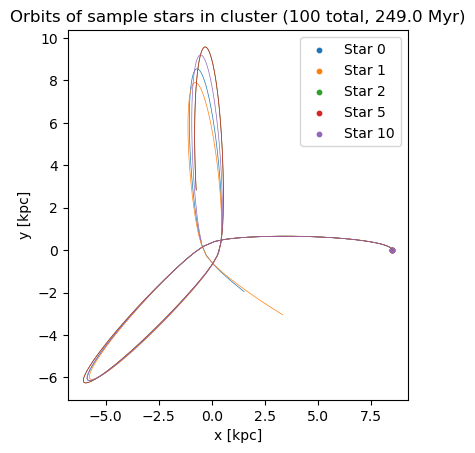

In [20]:
# ---------- Optional plotting ----------
# plt.figure(figsize=(6,6))
for sid in [0, 1, 2, 5, 10]:
    xs = [p[2] for p in positions if p[1] == sid]
    ys = [p[3] for p in positions if p[1] == sid]
    plt.plot(xs, ys, lw=0.5)
    plt.scatter(xs[0], ys[0], s=10, label=f"Star {sid}")
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title(f"Orbits of sample stars in cluster ({N} total, {max(times)})")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

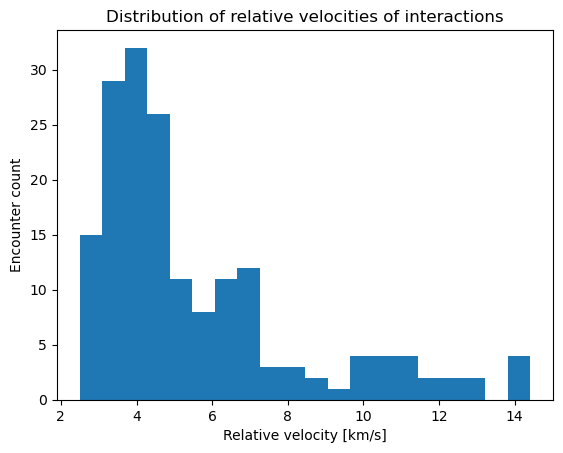

In [13]:
v_rel = np.array(interactions)[:,10]

# plt.figure(figsize=(6,6))
plt.hist(v_rel, bins=20)
plt.xlabel("Relative velocity [km/s]")
plt.ylabel("Encounter count")
plt.title("Distribution of relative velocities of interactions")
plt.show()

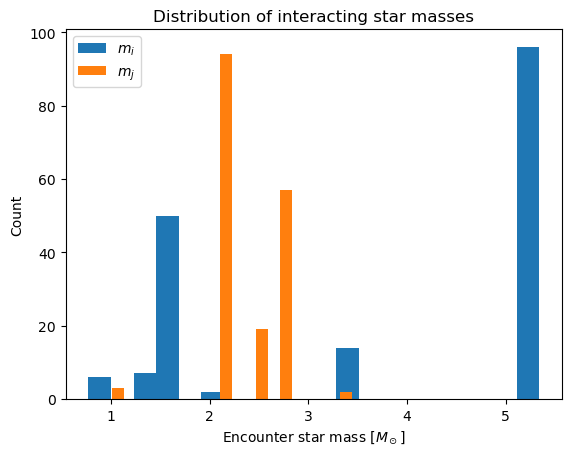

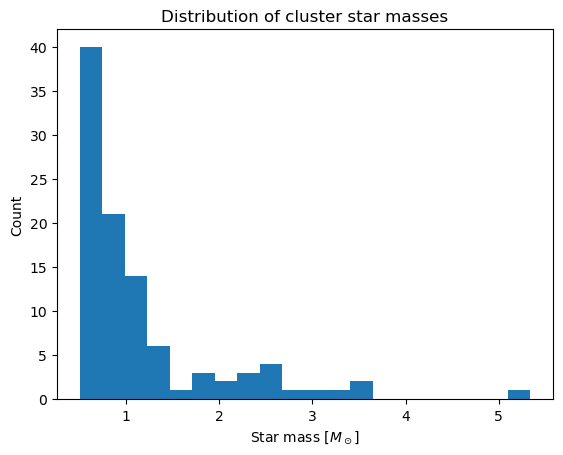

In [22]:
m_i = np.array(interactions)[:,11]
m_j = np.array(interactions)[:,12]
cluster_masses = [cluster.mass[i].value_in(units.MSun) for i in range(N)]
cluster_radii = [cluster.radius[i].value_in(units.RSun) for i in range(N)]

# plt.figure(figsize=(6,6))
plt.hist(m_i, bins=20, label='$m_i$')
plt.hist(m_j, bins=20, label='$m_j$')
plt.xlabel(r"Encounter star mass [$M_\odot$]")
plt.ylabel("Count")
plt.title("Distribution of interacting star masses")
plt.legend()
plt.show()

plt.hist(cluster_masses, bins=20)
plt.xlabel(r"Star mass [$M_\odot$]")
plt.ylabel("Count")
plt.title("Distribution of cluster star masses")
plt.show()